In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import pandas as pd

2022-11-19 07:25:18.634140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 07:25:33.138203: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 07:25:33.138235: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-19 07:25:34.376608: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-19 07:25:55.820774: W tensorflow/stream_executor/platform/de

In [2]:
CLASSES5 = ['angry', 'happy', 'neutral', 'sad', 'surprise']
CLASSES6 = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
CLASSES7 = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [3]:
folder_name = 'vggish_emb'
# Load the model.
# model = hub.load('https://tfhub.dev/google/yamnet/1')
model = hub.load('https://tfhub.dev/google/vggish/1')

2022-11-19 07:27:31.190506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 07:27:31.190796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 07:27:31.190891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-19 07:27:31.190947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-19 07:27:31.191038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [4]:
df = pd.read_csv('../Datasets/custom_db/df.csv')
df['file'] = df['file'].apply(lambda x: '../Datasets/custom_db/' + x[2:])
df

,file,emotion,split,dataset,augmentation,language
0,../Datasets/custom_db/tess/train/angry_1068.wav,angry,train,tess,none,en
1,../Datasets/custom_db/tess/train/surprise_1286...,surprise,train,tess,none,en
2,../Datasets/custom_db/tess/train/fear_248.wav,fear,train,tess,none,en
3,../Datasets/custom_db/tess/train/happy_2790.wav,happy,train,tess,none,en
4,../Datasets/custom_db/tess/train/surprise_139.wav,surprise,train,tess,none,en
...,...,...,...,...,...,...
92777,../Datasets/custom_db/bser/augment/happy_1017_...,happy,augment,bser,freqmask,bn
92778,../Datasets/custom_db/bser/augment/happy_660_p...,happy,augment,bser,pitchshift,bn
92779,../Datasets/custom_db/bser/augment/neutral_479...,neutral,augment,bser,freqmask,bn
92780,../Datasets/custom_db/bser/augment/happy_841_t...,happy,augment,bser,timemask,bn


In [5]:
def get_embeddings(filename, label):
    data, sr = librosa.load(filename, sr=None, mono=True, res_type='kaiser_best')

    if sr != 16000:
        raise ValueError('Sample rate is not 16kHz!')

    embeddings = model(data)
    # _, embeddings, _ = model(data)
    num_embeddings = tf.shape(embeddings)[0]
    return embeddings, tf.repeat(label, num_embeddings)

frame_length = 9288
frame_step = frame_length // 2


def get_embeddings_v2(filename, label):
    data, sr = librosa.load(filename, sr=None, mono=True, res_type='kaiser_best')
    data = tf.convert_to_tensor(data, dtype=tf.float32)
    clips = tf.signal.frame(
        data, frame_length=frame_length, frame_step=frame_step)
    batch_labels = tf.repeat(tf.expand_dims(label, 0), len(clips))
    batch_labels = batch_labels.numpy()

    print(len(clips[0]))

    embs = []
    for clip in clips:
        # _, embeddings, _ = model(clip)
        embeddings = model(clip)
        print(embeddings)
        embedding = np.mean(embeddings, axis=0)
        embs.append(embedding)
    embs = np.array(embs)

    return embs, batch_labels

def get_embeddings_v3(filename, label):
    data, sr = librosa.load(filename, sr=None, mono=True, res_type='kaiser_best')

    if len(data) < 16000:
        # data = np.pad(data, (0, 16000 - len(data)), 'constant')
        raise ValueError('Audio length is less than 1 second!')
    if sr != 16000:
        raise ValueError('Sample rate is not 16kHz!')


    # embeddings = model(data)
    _, embeddings, _ = model(data)
    num_embeddings = tf.shape(embeddings)[0]
    return embeddings, tf.repeat(label, num_embeddings).numpy()

    # print(len(clips[0]))

    # embs = []
    # for clip in clips:
    #     # _, embeddings, _ = model(clip)
    #     embeddings = model(clip)
    #     print(embeddings)
    #     embedding = np.mean(embeddings, axis=0)
    #     embs.append(embedding)
    # embs = np.array(embs)

    # return embs, batch_labels

In [6]:
# r, s = get_embeddings(df['file'][86223], df['emotion'][86223])
# r, s = get_embeddings(df['file'][0], df['emotion'][0])

In [7]:
# r.shape, s.shape

In [8]:
# p, q = get_embeddings_v3(df['file'][86223], df['emotion'][86223])
# # p, q = get_embeddings_v3(df['file'][0], df['emotion'][0])

In [9]:
# p, q

In [10]:
def save_embeddings(df, filename, split):
    features = []
    labels = []

    if df['emotion'].nunique() == 6:
        classes = CLASSES6
    elif df['emotion'].nunique() == 5:
        classes = CLASSES5
    else:
        classes = CLASSES7

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        embs, label = get_embeddings_v3(row['file'], row['emotion'])
        assert(len(embs) == len(label))
        features.extend(embs)
        labels.extend(label)

        # for i in range(embs.shape[0]):
        #     features.append(embs[i])
        #     labels.append(classes.index(label[i]))
    
    features = np.array(features)
    labels = np.array(labels)
    np.save(filename + split + '_X.npy', features)
    np.save(filename + split + '_y.npy', labels)

In [54]:
ravdess = df[df['dataset'] == 'ravdess']

train_aug = ravdess[(ravdess['split'] == 'train') | (ravdess['split'] == 'augment')]
train = ravdess[ravdess['split'] == 'train']
val = ravdess[ravdess['split'] == 'val']
test = ravdess[ravdess['split'] == 'test']

save_embeddings(train_aug, f'./features/{folder_name}/ravdess/', 'train_aug')
save_embeddings(train, f'./features/{folder_name}/ravdess/', 'train')
save_embeddings(val, f'./features/{folder_name}/ravdess/', 'val')
save_embeddings(test, f'./features/{folder_name}/ravdess/', 'test')

100%|██████████| 288/288 [00:12<00:00, 23.12it/s]


In [49]:
savee = df[df['dataset'] == 'savee']

train_aug = savee[(savee['split'] == 'train') | (savee['split'] == 'augment')]
train = savee[savee['split'] == 'train']
val = savee[savee['split'] == 'val']
test = savee[savee['split'] == 'test']

save_embeddings(train_aug, f'./features/{folder_name}/savee/', 'train_aug')
save_embeddings(train, f'./features/{folder_name}/savee/', 'train')
save_embeddings(val, f'./features/{folder_name}/savee/', 'val')
save_embeddings(test, f'./features/{folder_name}/savee/', 'test')

100%|██████████| 96/96 [00:04<00:00, 20.25it/s]


In [55]:
tess = df[df['dataset'] == 'tess']

train_aug = tess[(tess['split'] == 'train') | (tess['split'] == 'augment')]
train = tess[tess['split'] == 'train']
val = tess[tess['split'] == 'val']
test = tess[tess['split'] == 'test']

save_embeddings(train_aug, f'./features/{folder_name}/tess/', 'train_aug')
save_embeddings(train, f'./features/{folder_name}/tess/', 'train')
save_embeddings(val, f'./features/{folder_name}/tess/', 'val')
save_embeddings(test, f'./features/{folder_name}/tess/', 'test')

100%|██████████| 560/560 [00:21<00:00, 26.16it/s]


In [56]:
crema = df[df['dataset'] == 'crema']

train_aug = crema[(crema['split'] == 'train') | (crema['split'] == 'augment')]
train = crema[crema['split'] == 'train']
val = crema[crema['split'] == 'val']
test = crema[crema['split'] == 'test']

save_embeddings(train_aug, f'./features/{folder_name}/crema/', 'train_aug')
save_embeddings(train, f'./features/{folder_name}/crema/', 'train')
save_embeddings(val, f'./features/{folder_name}/crema/', 'val')
save_embeddings(test, f'./features/{folder_name}/crema/', 'test')

100%|██████████| 1489/1489 [01:14<00:00, 19.92it/s]


In [57]:
subesco = df[df['dataset'] == 'subesco']

train_aug = subesco[(subesco['split'] == 'train') | (subesco['split'] == 'augment')]
train = subesco[subesco['split'] == 'train']
val = subesco[subesco['split'] == 'val']
test = subesco[subesco['split'] == 'test']

save_embeddings(train_aug, f'./features/{folder_name}/subesco/', 'train_aug')
save_embeddings(train, f'./features/{folder_name}/subesco/', 'train')
save_embeddings(val, f'./features/{folder_name}/subesco/', 'val')
save_embeddings(test, f'./features/{folder_name}/subesco/', 'test')

100%|██████████| 1400/1400 [01:09<00:00, 20.12it/s]


In [58]:
bser = df[df['dataset'] == 'bser']

train_aug = bser[(bser['split'] == 'train') | (bser['split'] == 'augment')]
train = bser[bser['split'] == 'train']
val = bser[bser['split'] == 'val']
test = bser[bser['split'] == 'test']

save_embeddings(train_aug, f'./features/{folder_name}/bser/', 'train_aug')
save_embeddings(train, f'./features/{folder_name}/bser/', 'train')
save_embeddings(val, f'./features/{folder_name}/bser/', 'val')
save_embeddings(test, f'./features/{folder_name}/bser/', 'test')

100%|██████████| 294/294 [00:10<00:00, 29.38it/s]


In [59]:
all_en = df[df['language'] == 'en']

train_aug = all_en[(all_en['split'] == 'train') | (all_en['split'] == 'augment')]
train = all_en[all_en['split'] == 'train']
val = all_en[all_en['split'] == 'val']
test = all_en[all_en['split'] == 'test']

save_embeddings(train_aug, f'./features/{folder_name}/all_en/', 'train_aug')
save_embeddings(train, f'./features/{folder_name}/all_en/', 'train')
save_embeddings(val, f'./features/{folder_name}/all_en/', 'val')
save_embeddings(test, f'./features/{folder_name}/all_en/', 'test')

100%|██████████| 2433/2433 [01:50<00:00, 22.09it/s]


In [11]:
all_bn = df[df['language'] == 'bn']

train_aug = all_bn[(all_bn['split'] == 'train') | (all_bn['split'] == 'augment')]
train = all_bn[all_bn['split'] == 'train']
val = all_bn[all_bn['split'] == 'val']
test = all_bn[all_bn['split'] == 'test']

save_embeddings(train_aug, f'./features/{folder_name}/all_bn/', 'train_aug')
save_embeddings(train, f'./features/{folder_name}/all_bn/', 'train')
save_embeddings(val, f'./features/{folder_name}/all_bn/', 'val')
save_embeddings(test, f'./features/{folder_name}/all_bn/', 'test')

100%|██████████| 1694/1694 [01:17<00:00, 21.93it/s]


In [12]:
all = df

train_aug = all[(all['split'] == 'train') | (all['split'] == 'augment')]
train = all[all['split'] == 'train']
val = all[all['split'] == 'val']
test = all[all['split'] == 'test']

save_embeddings(train_aug, f'./features/{folder_name}/all/', 'train_aug')
save_embeddings(train, f'./features/{folder_name}/all/', 'train')
save_embeddings(val, f'./features/{folder_name}/all/', 'val')
save_embeddings(test, f'./features/{folder_name}/all/', 'test')

100%|██████████| 4127/4127 [03:07<00:00, 22.03it/s]


In [ ]:
stop

# Testing

In [40]:
X = np.load(f'./features/{folder_name}/all/train_X.npy', allow_pickle=True)
y = np.load(f'./features/{folder_name}/all/train_y.npy', allow_pickle=True)

# a = np.load(f'./features/{folder_name}/all/val_X.npy', allow_pickle=True)
# b = np.load(f'./features/{folder_name}/all/val_y.npy', allow_pickle=True)

# X = np.concatenate((X, a), axis=0)
# y = np.concatenate((y, b), axis=0)

# a = np.load(f'./features/{folder_name}/all/test_X.npy', allow_pickle=True)
# b = np.load(f'./features/{folder_name}/all/test_y.npy', allow_pickle=True)

# X = np.concatenate((X, a), axis=0)
# y = np.concatenate((y, b), axis=0)

In [38]:
X.shape, y.shape

((24972, 128), (24972,))

In [ ]:
X[200]

In [16]:
y[200]

b'disgust'

[b'angry' b'disgust' b'fear' b'happy' b'neutral' b'sad' b'surprise'] [3315 4083 3552 3462 3922 4518 2120]


/home/sam/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

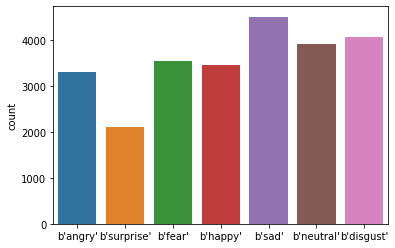

In [41]:
import seaborn as sns

unique_items, counts = np.unique(y, return_counts=True)
print(unique_items, counts)

sns.countplot(y)

In [25]:
from sklearn.utils import class_weight

In [42]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

In [43]:
class_weights = dict(zip(np.unique(y), class_weights))
class_weights

{b'angry': 1.076147382029735,
 b'disgust': 0.8737273013540464,
 b'fear': 1.0043436293436294,
 b'happy': 1.03045308244615,
 b'neutral': 0.9095942303489474,
 b'sad': 0.78960349079871,
 b'surprise': 1.6827493261455526}

# Spectogram

In [ ]:
from math import ceil


def plot_embeddings(df, name):

    if df['Emotion'].nunique() == 6:
        classes = CLASSES6
    else:
        classes = CLASSES7

    fig, axs = plt.subplots(2, ceil(len(classes) / 2), figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .3, wspace=.3)
    fig.suptitle(f'{name} VGGish Embeddings')
    fig.tight_layout()
    axs = axs.ravel()

    for i in range(len(classes)):
        emb = get_embeddings(df[df['Emotion'] == classes[i]]['File_Path'].iloc[0], df[df['Emotion'] == classes[i]]['Emotion'].iloc[0])
        axs[i].plot(emb[0][0])
        # axs[i].imshow(emb[0].numpy(), aspect='auto', interpolation='nearest', origin='lower', cmap='jet')
        axs[i].set_title(classes[i])
    # plt.legend()
    # plt.show()

In [ ]:
plot_embeddings(tess, 'TESS')

In [ ]:
plot_embeddings(savee, 'SAVEE')

In [ ]:
plot_embeddings(ravdess, 'RAVDESS')

In [ ]:
plot_embeddings(crema, 'CREMA')